# Lab 6: Regularization and Optimization

Ren Yi, 3-28-2019

The goal of this lab is to learn how to apply different regularization and optimization strategies in PyTorch using MNIST data.

Here a imcomplete list of the techniques we've covered in class
- Regularization
    - L1/L2 regularization
    - Data augmentation
    - Dropout
    - Batch normalization
    - Early stopping
- Optimization
    - SGD (with momentum)
    - Nesterov momentum
    - AdaGrad
    - RMSProp
    - Adam
    
We will show you how some of these methods are used in PyTorch. 

## Problem Setup

In [1]:
import pickle 
import time
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Initialize necessary parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(717)

seed = 345
batch_size = 50
test_batch_size = 20
input_size = 28 * 28
output_size = 10
n_feature = 3
optim_results = {}

In [3]:
# Data Loader
trainset = datasets.MNIST('data', train=True, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))]))
testset = datasets.MNIST('data', train=False, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))]))

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=True)

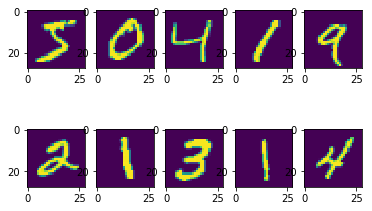

In [4]:
## show some images
plt.figure()
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())

In [5]:
def train(model, optimizer, num_epoch=1, print_every=100):
    train_losses =[]
    test_losses =[]
    start_time = time.time()

    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(num_epoch):
        # Training step
        model.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % print_every == 0:
                print('Train set | epoch: {:3d} | {:6d}/{:6d} batches | Loss: {:6.4f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))
                train_loss += loss.item()

                train_loss /=len(train_loader)
                train_losses.append(train_loss)

        # testing step
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += loss_fn(output, target).item()
                pred = output.data.max(1)[1] # get the index of the max log-probability
                correct += pred.eq(target.data).cpu().sum()

            test_loss /= len(test_loader) # loss function already averages over batch size
            elapse = time.strftime('%H:%M:%S', time.gmtime(int((time.time() - start_time))))
            print('Test set | Average loss: {:6.4f} | Accuracy: {:4.2f}% | time elapse: {:>9}'.format(
                test_loss, 100. * correct / len(test_loader.dataset), elapse))

            test_losses.append(test_loss)

    return train_losses, test_losses

def populate_result(dictionary, method, train_loss, val_loss):
    dictionary[method] = {}
    dictionary[method]['train_loss'] = np.array(train_loss)
    dictionary[method]['val_loss'] = np.array(val_loss)
    
def plot_loss(result, loss='train_loss', ylim=None):
    plt.plot(result['Baseline'][loss], label='Baseline')
    for k in result.keys():
        if k != 'Baseline':
            plt.plot(result[k][loss], label=k)
    if ylim is not None:
        plt.ylim(ylim)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_best_loss(result, loss='val_loss'):
    labels = ['Baseline']
    acc = [np.max(result['Baseline'][loss])]
    for k in result.keys():
        if k != 'Baseline':
            labels.append(k)
            acc.append(np.max(result[k][loss]))

    x = np.arange(len(labels))
    plt.barh(x, acc)
    plt.yticks(x, labels)
    plt.xlabel('Loss')
    plt.show()

### Baseline method

We will later show how different optimization and regularization techniques can improve baseline model performance. But first,
1. What's our baseline model architecture?
2. What's the optimization method used to train the baseline model?
3. How does this optimization method update its parameters.
$$\theta_{t+1} = \theta_{t} - \eta \nabla J(\theta_{t})$$
where $\eta$ denotes the learning rate

In [6]:
class Baseline(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(Baseline, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Sequential(nn.Conv2d(1, n_feature, kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(nn.Conv2d(n_feature, n_feature, kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
        self.fc = nn.Sequential(nn.Linear(n_feature*4*4, 50),
                                nn.ReLU(),
                                nn.Linear(50, 10))


    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc(x)
        return x

In [7]:
torch.manual_seed(seed)
model = Baseline(input_size, n_feature, output_size).to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01)
train_losses, test_losses = train(model, optimizer)
populate_result(optim_results, 'Baseline', train_losses, test_losses)

Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3009
Train set | epoch:   0 |   5000/ 60000 batches | Loss: 2.2815
Train set | epoch:   0 |  10000/ 60000 batches | Loss: 2.1954
Train set | epoch:   0 |  15000/ 60000 batches | Loss: 1.2858
Train set | epoch:   0 |  20000/ 60000 batches | Loss: 0.7166
Train set | epoch:   0 |  25000/ 60000 batches | Loss: 0.6110
Train set | epoch:   0 |  30000/ 60000 batches | Loss: 0.4446
Train set | epoch:   0 |  35000/ 60000 batches | Loss: 0.3804
Train set | epoch:   0 |  40000/ 60000 batches | Loss: 0.5608
Train set | epoch:   0 |  45000/ 60000 batches | Loss: 0.5815
Train set | epoch:   0 |  50000/ 60000 batches | Loss: 0.6137
Train set | epoch:   0 |  55000/ 60000 batches | Loss: 0.4413
Test set | Average loss: 0.3368 | Accuracy: 89.00% | time elapse:  00:00:23


## Fancier Optimization

https://pytorch.org/docs/stable/optim.html

### SGD with momentum
1. How does SGD with momentum update its parameters?
$$v_{t+1} = \rho v_{t} + \nabla J(\theta_{t})$$
$$\theta_{t+1} = \theta_{t} - \eta v_{t+1}$$
where $v$ and $\rho$ denote velocity and momentum, respectively.
2. Check out the documentation for SGD in PyTorch and complete the code below (Set momentum=0.5). 

In [8]:
torch.manual_seed(seed)
model = Baseline(input_size, n_feature, output_size).to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.5)
train_losses, test_losses = train(model, optimizer)
populate_result(optim_results, 'SGD_momentum', train_losses, test_losses)

Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3009
Train set | epoch:   0 |   5000/ 60000 batches | Loss: 2.2001
Train set | epoch:   0 |  10000/ 60000 batches | Loss: 0.8082
Train set | epoch:   0 |  15000/ 60000 batches | Loss: 0.5519
Train set | epoch:   0 |  20000/ 60000 batches | Loss: 0.3707
Train set | epoch:   0 |  25000/ 60000 batches | Loss: 0.5029
Train set | epoch:   0 |  30000/ 60000 batches | Loss: 0.3694
Train set | epoch:   0 |  35000/ 60000 batches | Loss: 0.3064
Train set | epoch:   0 |  40000/ 60000 batches | Loss: 0.4735
Train set | epoch:   0 |  45000/ 60000 batches | Loss: 0.4783
Train set | epoch:   0 |  50000/ 60000 batches | Loss: 0.4766
Train set | epoch:   0 |  55000/ 60000 batches | Loss: 0.2614
Test set | Average loss: 0.2324 | Accuracy: 92.00% | time elapse:  00:00:22


### Nesterov momentum

Make a minor change in the above code to apply Nesterov momentum (Set momentum=0.5). 

In [9]:
torch.manual_seed(seed)
model = Baseline(input_size, n_feature, output_size).to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.5, nesterov=True)
train_losses, test_losses = train(model, optimizer)
populate_result(optim_results, 'Nesterov_momentum', train_losses, test_losses)

Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3009
Train set | epoch:   0 |   5000/ 60000 batches | Loss: 2.1939
Train set | epoch:   0 |  10000/ 60000 batches | Loss: 0.8151
Train set | epoch:   0 |  15000/ 60000 batches | Loss: 0.5552
Train set | epoch:   0 |  20000/ 60000 batches | Loss: 0.3903
Train set | epoch:   0 |  25000/ 60000 batches | Loss: 0.4664
Train set | epoch:   0 |  30000/ 60000 batches | Loss: 0.3572
Train set | epoch:   0 |  35000/ 60000 batches | Loss: 0.3376
Train set | epoch:   0 |  40000/ 60000 batches | Loss: 0.4086
Train set | epoch:   0 |  45000/ 60000 batches | Loss: 0.4967
Train set | epoch:   0 |  50000/ 60000 batches | Loss: 0.4545
Train set | epoch:   0 |  55000/ 60000 batches | Loss: 0.2577
Test set | Average loss: 0.2315 | Accuracy: 92.00% | time elapse:  00:00:23


### AdaGrad

1. What's the motivation of AdaGrad?
2. Check out the documentation of AdaGrad in PyTorch and complete the code below. 

In [10]:
torch.manual_seed(seed)
model = Baseline(input_size, n_feature, output_size).to(device)
optimizer = optim.Adagrad(model.parameters(),lr=0.01)
train_losses, test_losses = train(model, optimizer)
populate_result(optim_results, 'AdaGrad', train_losses, test_losses)

Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3009
Train set | epoch:   0 |   5000/ 60000 batches | Loss: 0.3055
Train set | epoch:   0 |  10000/ 60000 batches | Loss: 0.4332
Train set | epoch:   0 |  15000/ 60000 batches | Loss: 0.4288
Train set | epoch:   0 |  20000/ 60000 batches | Loss: 0.3332
Train set | epoch:   0 |  25000/ 60000 batches | Loss: 0.3472
Train set | epoch:   0 |  30000/ 60000 batches | Loss: 0.2991
Train set | epoch:   0 |  35000/ 60000 batches | Loss: 0.3374
Train set | epoch:   0 |  40000/ 60000 batches | Loss: 0.4840
Train set | epoch:   0 |  45000/ 60000 batches | Loss: 0.4880
Train set | epoch:   0 |  50000/ 60000 batches | Loss: 0.5246
Train set | epoch:   0 |  55000/ 60000 batches | Loss: 0.3923
Test set | Average loss: 0.2852 | Accuracy: 91.00% | time elapse:  00:00:22


### RMSprop

In [11]:
torch.manual_seed(seed)
model = Baseline(input_size, n_feature, output_size).to(device)
optimizer = optim.RMSprop(model.parameters(),lr=0.01, alpha=0.9)
train_losses, test_losses = train(model, optimizer)
populate_result(optim_results, 'RMSprop', train_losses, test_losses)

Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3009
Train set | epoch:   0 |   5000/ 60000 batches | Loss: 0.2331
Train set | epoch:   0 |  10000/ 60000 batches | Loss: 0.3503
Train set | epoch:   0 |  15000/ 60000 batches | Loss: 0.3192
Train set | epoch:   0 |  20000/ 60000 batches | Loss: 0.1483
Train set | epoch:   0 |  25000/ 60000 batches | Loss: 0.1606
Train set | epoch:   0 |  30000/ 60000 batches | Loss: 0.0921
Train set | epoch:   0 |  35000/ 60000 batches | Loss: 0.0995
Train set | epoch:   0 |  40000/ 60000 batches | Loss: 0.2630
Train set | epoch:   0 |  45000/ 60000 batches | Loss: 0.2252
Train set | epoch:   0 |  50000/ 60000 batches | Loss: 0.1872
Train set | epoch:   0 |  55000/ 60000 batches | Loss: 0.3259
Test set | Average loss: 0.1290 | Accuracy: 95.00% | time elapse:  00:00:22


### Adam

In [12]:
torch.manual_seed(seed)
model = Baseline(input_size, n_feature, output_size).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01, betas=(0.9, 0.99))
train_losses, test_losses = train(model, optimizer)
populate_result(optim_results, 'Adam', train_losses, test_losses)

Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3009
Train set | epoch:   0 |   5000/ 60000 batches | Loss: 0.2129
Train set | epoch:   0 |  10000/ 60000 batches | Loss: 0.2242
Train set | epoch:   0 |  15000/ 60000 batches | Loss: 0.3804
Train set | epoch:   0 |  20000/ 60000 batches | Loss: 0.2660
Train set | epoch:   0 |  25000/ 60000 batches | Loss: 0.3952
Train set | epoch:   0 |  30000/ 60000 batches | Loss: 0.0943
Train set | epoch:   0 |  35000/ 60000 batches | Loss: 0.0761
Train set | epoch:   0 |  40000/ 60000 batches | Loss: 0.1887
Train set | epoch:   0 |  45000/ 60000 batches | Loss: 0.1526
Train set | epoch:   0 |  50000/ 60000 batches | Loss: 0.1002
Train set | epoch:   0 |  55000/ 60000 batches | Loss: 0.1275
Test set | Average loss: 0.1224 | Accuracy: 96.00% | time elapse:  00:00:22


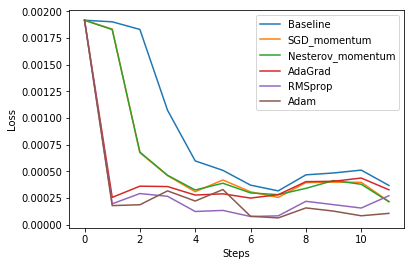

In [13]:
# Plot optimization methods training results
plot_loss(optim_results)

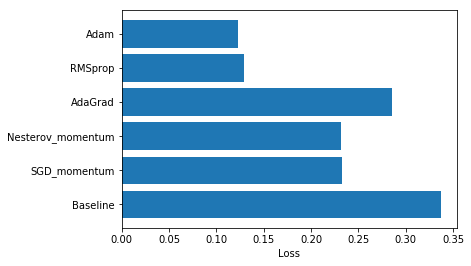

In [14]:
# Plot optimization methods validation results
plot_best_loss(optim_results)

## Regularization

https://pytorch.org/docs/stable/nn.html

In [7]:
# In order to see effects of regularization on validation set, we need to make some slight modification

## Smaller training set
trainset.train_data=trainset.train_data[:6000]
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

## Longer training epochs
train_epoches = 100
print_every = 500
reg_results = {}

### Baseline model

In [274]:
torch.manual_seed(seed)
model = Baseline(input_size, n_feature, output_size).to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01)
train_losses, test_losses = train(model, optimizer, num_epoch=train_epoches, print_every=print_every)
populate_result(reg_results, 'Baseline', train_losses, test_losses)

Train set | epoch:   0 |      0/  6000 batches | Loss: 2.2979
Test set | Average loss: 2.2626 | Accuracy: 17.00% | time elapse:  00:00:03
Train set | epoch:   1 |      0/  6000 batches | Loss: 2.2325
Test set | Average loss: 1.9507 | Accuracy: 47.00% | time elapse:  00:00:06
Train set | epoch:   2 |      0/  6000 batches | Loss: 2.0527
Test set | Average loss: 0.8042 | Accuracy: 73.00% | time elapse:  00:00:09
Train set | epoch:   3 |      0/  6000 batches | Loss: 0.5708
Test set | Average loss: 0.5588 | Accuracy: 82.00% | time elapse:  00:00:12
Train set | epoch:   4 |      0/  6000 batches | Loss: 0.6719
Test set | Average loss: 0.5651 | Accuracy: 81.00% | time elapse:  00:00:15
Train set | epoch:   5 |      0/  6000 batches | Loss: 0.3838
Test set | Average loss: 0.4438 | Accuracy: 85.00% | time elapse:  00:00:18
Train set | epoch:   6 |      0/  6000 batches | Loss: 0.5457
Test set | Average loss: 0.4684 | Accuracy: 84.00% | time elapse:  00:00:21
Train set | epoch:   7 |      0/  

### L1/L2 regularization

L2 regularization is included in most optimizers in PyTorch and can be controlled with the __weight_decay__ parameter.
For L1 regularization, check out this post: https://discuss.pytorch.org/t/simple-l2-regularization/139

### Adding Dropout Layer

1. How does Dropout introduce regularization effect?
2. Check out documentations for __nn.Dropout()__. Modify the Baseline model and add dropout layer to the fully connected layers.
3. Optionally, you may also check out documentations for __nn.Dropout2d()__ to learn how to add Dropout layer to convolution layers.

In [8]:
class DropoutNet(nn.Module):
    def __init__(self, input_size, n_feature, output_size, dropout_rate=0.5):
        super(DropoutNet, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Sequential(nn.Conv2d(1, n_feature, kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
        
        self.conv2 = nn.Sequential(nn.Conv2d(n_feature, n_feature, kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
        self.fc = nn.Sequential(nn.Linear(n_feature*4*4, 50),
                                nn.ReLU(),
                                nn.Dropout(dropout_rate),
                                nn.Linear(50, 10))


    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc(x)
        return x

In [9]:
torch.manual_seed(seed)
model = DropoutNet(input_size, n_feature, output_size, dropout_rate=0.5).to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01)
train_losses, test_losses = train(model, optimizer, num_epoch=train_epoches, print_every=print_every)
populate_result(reg_results, 'Dropout', train_losses, test_losses)

Train set | epoch:   0 |      0/  6000 batches | Loss: 2.2954
Test set | Average loss: 2.2714 | Accuracy: 13.00% | time elapse:  00:00:06
Train set | epoch:   1 |      0/  6000 batches | Loss: 2.2850
Test set | Average loss: 2.1575 | Accuracy: 33.00% | time elapse:  00:00:13
Train set | epoch:   2 |      0/  6000 batches | Loss: 2.1633
Test set | Average loss: 1.4400 | Accuracy: 63.00% | time elapse:  00:00:19
Train set | epoch:   3 |      0/  6000 batches | Loss: 1.4984
Test set | Average loss: 0.8572 | Accuracy: 76.00% | time elapse:  00:00:25
Train set | epoch:   4 |      0/  6000 batches | Loss: 1.1382
Test set | Average loss: 0.6734 | Accuracy: 80.00% | time elapse:  00:00:31
Train set | epoch:   5 |      0/  6000 batches | Loss: 0.7308
Test set | Average loss: 0.5552 | Accuracy: 83.00% | time elapse:  00:00:37
Train set | epoch:   6 |      0/  6000 batches | Loss: 0.8309
Test set | Average loss: 0.5258 | Accuracy: 84.00% | time elapse:  00:00:43
Train set | epoch:   7 |      0/  

### Adding Batch Normalization
1. What's the advantage of using batch normalization?
    1. Allow each layer to train relatively more independently
    2. Improve gradient flow through the network
    3. Allows higher learning rate
    4. Reduces strong dependence on initialization
2. Batch normalization also act as a form of regularization, why?
3. Implement batch normalization in __BatchnormNet__. Think about where you may want to insert the batch normalization layer.

In [287]:
class BatchnormNet(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(BatchnormNet, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Sequential(nn.Conv2d(1, n_feature, kernel_size=5),
                                   nn.MaxPool2d(2),
                                   nn.ReLU())
        
        self.conv2 = nn.Sequential(nn.Conv2d(n_feature, n_feature, kernel_size=5),
                                   nn.MaxPool2d(2),
                                   nn.ReLU())
        self.fc = nn.Sequential(nn.Linear(n_feature*4*4, 50),
        						nn.BatchNorm1d(50),
                                nn.ReLU(),
                                nn.Linear(50, 10))


    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc(x)
        return x

In [288]:
torch.manual_seed(seed)
model = BatchnormNet(input_size, n_feature, output_size).to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01)
train_losses, test_losses = train(model, optimizer, num_epoch=train_epoches, print_every=print_every)
populate_result(reg_results, 'Batchnorm', train_losses, test_losses)

Train set | epoch:   0 |      0/  6000 batches | Loss: 2.3421
Test set | Average loss: 1.9277 | Accuracy: 50.00% | time elapse:  00:00:03
Train set | epoch:   1 |      0/  6000 batches | Loss: 1.9370
Test set | Average loss: 1.6515 | Accuracy: 63.00% | time elapse:  00:00:06
Train set | epoch:   2 |      0/  6000 batches | Loss: 1.6887
Test set | Average loss: 1.3800 | Accuracy: 71.00% | time elapse:  00:00:09
Train set | epoch:   3 |      0/  6000 batches | Loss: 1.3704
Test set | Average loss: 1.1584 | Accuracy: 76.00% | time elapse:  00:00:12
Train set | epoch:   4 |      0/  6000 batches | Loss: 1.1900
Test set | Average loss: 0.9580 | Accuracy: 82.00% | time elapse:  00:00:15
Train set | epoch:   5 |      0/  6000 batches | Loss: 0.9490
Test set | Average loss: 0.7900 | Accuracy: 86.00% | time elapse:  00:00:18
Train set | epoch:   6 |      0/  6000 batches | Loss: 0.9021
Test set | Average loss: 0.6547 | Accuracy: 88.00% | time elapse:  00:00:21
Train set | epoch:   7 |      0/  

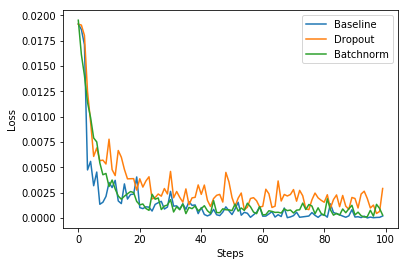

In [291]:
plot_loss(reg_results)

Validation loss using Dropout and Batchnorm start to catch up with the loss of baseline model after baseline model overfits training data.

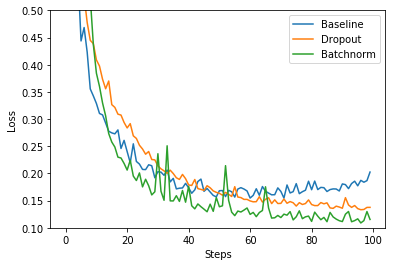

In [292]:
plot_loss(reg_results, loss = 'val_loss', ylim=(0.1, 0.5))

## Exercise: parameter tunning

We've introduced multiple regularization and optimization techniques to improve your model. How can you combine these techniques and perform grid search to find out a set of parameters that maximize your model performance on validation set? Are there other model architectures you'd like to try?